In [2]:
import csv 
import cv2
import tensorflow as tf
import keras.backend as ktf
import numpy as np

lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    first = True
    for line in reader:
        if first :
            first = False
            continue
        lines.append(line)

images = []
measurements = []
LEFT_CORR = 0.1
RIGHT_CORR = 0.2
DROP_RATE = 0.50
	
for line in lines:
    centre_file = './data/IMG/'+ line[0].split('/')[-1]
    left_file   = './data/IMG/'+ line[1].split('/')[-1]
    right_file  = './data/IMG/'+ line[2].split('/')[-1]
    if np.random.uniform() < DROP_RATE:
        image = cv2.imread(centre_file )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image =image[60:140,:,:]
        measurement = float(line[3])
        images.append(image)
        measurements.append(measurement)
    
    #image =cv2.resize(image, (64,64))
    #if measurement > -0.05 && measurement < 0.05:
    image = cv2.imread(left_file )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image =image[60:140,:,:]
    measurement = float(line[3]) + LEFT_CORR
    images.append(image)
    measurements.append(measurement)
    
    image = cv2.imread(right_file )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image =image[60:140,:,:]
    measurement = float(line[3]) - RIGHT_CORR
    images.append(image)
    measurements.append(measurement)

    
X_train = np.array(images)
y_train = np.array(measurements)

print('X_train.shape',X_train.shape)
print('y_train.shape',y_train.shape)
# Preprocessing

X_train.shape (20099, 80, 320, 3)
y_train.shape (20099,)


(array([1.99663080e-03, 6.43358814e-03, 5.87896848e-02, 3.36986910e-01,
        1.65099183e+00, 2.10200854e+00, 2.58009069e-01, 3.92670725e-02,
        3.54956587e-03, 8.87391468e-04]),
 array([-1.1426954 , -0.91842586, -0.69415632, -0.46988678, -0.24561724,
        -0.0213477 ,  0.20292184,  0.42719138,  0.65146092,  0.87573046,
         1.1       ]),
 <a list of 10 Patch objects>)

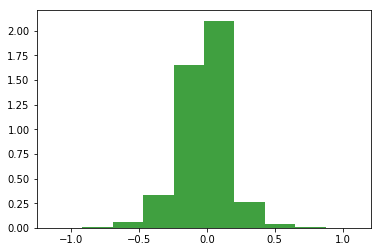

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(X_train[250])
plt.hist(y_train, normed=1, facecolor='green', alpha=0.75)

In [9]:
# Resize
def resize(X):

    #return ktf.resize_images(X,64.0/80, 64.0/320, "channels_first")
    import tensorflow as tf
    return tf.image.resize_images(X,[32,128])




#MODEL ARCHITECTURE

from keras.models import Sequential
from keras.layers import Flatten,Dense,Activation,Lambda,Convolution2D,Dropout

model = Sequential()
#model.add(Lambda(lambda x: x/127.5 - 1,input_shape = (64,64,3)))
model.add(Lambda(lambda x: x/127.5 - 1,input_shape = (80,320,3)))
model.add(Lambda(resize))

model.add(Convolution2D(6,3,3))
model.add(Activation('relu'))

model.add(Convolution2D(12,3,3))
model.add(Activation('relu'))

#model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(300))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(30))
model.add(Activation('relu'))

model.add(Dense(1))


model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5, batch_size = 128)
### print the keys contained in the history object
print(history_object.history.keys())

model.save('model.h5')


Train on 16079 samples, validate on 4020 samples
Epoch 1/5
16079/16079 [==============================] - 217s - loss: 0.0787 - val_loss: 0.0167
Epoch 2/5
16079/16079 [==============================] - 223s - loss: 0.0114 - val_loss: 0.0153
Epoch 3/5
16079/16079 [==============================] - 209s - loss: 0.0084 - val_loss: 0.0150
Epoch 4/5
16079/16079 [==============================] - 206s - loss: 0.0065 - val_loss: 0.0191
Epoch 5/5
16079/16079 [==============================] - 206s - loss: 0.0048 - val_loss: 0.0146
dict_keys(['val_loss', 'loss'])


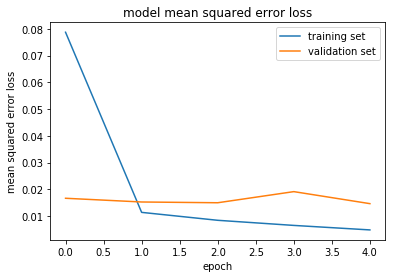

In [10]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()